<a id='BacktoTop'></a>

### SMU NLP Course (DS7337) -- Homework 05 submission  (07-01-2019)
### Shanqing Gu (Class 401)

###  Table of Contents 

#### Q1. [Compile a list of permalinks to individual user movie reviews from IMDb](#IMDbPermalinks) 
 * [Q1.1 - Compile a list of permalinks to individual user movie reviews from IMDb](#Q11Movies)
 * [Q1.2 - Get 953 movie reviews for the selected 47 IMDb top thriller movie](#Q12Reviews)

#### Q2. [Extract NP chunks from reviews](#NPChunks)
#### Q3. [Output all the chunks in a single list for each review](#OutputChunks)
 * [Summary](#Summary)

In [1]:
## Import libraries needed for HW5
import pandas as pd
import numpy as np
import requests
import pickle
import re
import urllib
import lxml
import contractions
import string
import nltk
import matplotlib.pyplot as plt
%matplotlib inline

from bs4 import BeautifulSoup
from requests import get
from urllib.request import urlopen
from urllib.parse import urljoin
from time import time, sleep
from random import randint
from IPython.core.display import clear_output
from warnings import warn
from string import punctuation
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from lxml import html
from pattern.en import parsetree, Chunk 

<a id='IMDbPermalinks'></a>
#### Q1: Compile a list of permalinks to individual user movie reviews from IMDb

Compile a list of static links (permalinks) to individual user movie reviews from one particular website. This will be your working dataset for this assignment, as well as for assignments 7 and 8, which together will make up your semester project.   

a.	It does not matter if you use a crawler or if you manually collect the links, but you will need at least 100 movie review links. Note that, as of this writing, the robots.txt file of IMDB.com allows the crawling of user reviews.

b.	Each link should be to a web page that has only one user review of only one movie, e.g., the user review permalinks on the IMDB site.

c.	Choose reviews of movies that are all in the same genre, e.g., sci-fi, mystery, romance, superhero, etc.  

d.	Make sure your collection includes reviews of several movies in your chosen genre and that it includes a mix of negative and positive reviews.  



[Back to top](#BacktoTop)

<a id='Q11Movies'></a>
#### Q1.1 : Get 47 IMDb top thriller movie links from 2018 to 2019

In this section, 47 thriller movie links from IMDb website are extracted with BeautifulSoup web scraping. The thriller movies dated from 2018 are selected with metascores in order to check if the collected reviews have positive and negative reviews. Metascore is the score of the movie on the metacritic website. Usually, "very good"(critical favorites) movies have scores above 70. From the IMDb rating and metascore distribution plots, the movie IMDb rankings are from 5 to 9, and metascores are from 3 to 10 (adjusted metascores are from 30 to 100). 

[Back to top](#BacktoTop)

In [2]:
## Scrape thriller movies with metascores from IMDb
## Metascore is the score of the movie on the metacritic website.
## Usually,"very good"(critical favorites) movies have scores above 70.
## Reference: https://www.dataquest.io/blog/web-scraping-beautifulsoup/

## Set pages and years to browse from IMDb websites

base = "http://www.imdb.com/"
headers = {"Accept-Language": "en-US, en;q=0.5"}

pages = [str(i) for i in range(1,2)]
years_url = [str(i) for i in range(2018,2019)]

In [3]:
## Lists to store scraped data
names = []
links = []

years = []
imdb_ratings = []
metascores = []
votes = []

## Preparing the loop monitoring
start_time = time()
requests = 0

## Years in range (2018, 2019)
for year_url in years_url:

    ## Pages in range (1, 2)
    for page in pages:

        # Make a get request       
        response = get(
            'http://www.imdb.com/search/title?release_date=' + year_url + '&sort=num_votes,desc&page=' + page,
            headers = headers)

        # Pause the loop
        sleep(randint(8,15))

        # Monitor the requests
        requests += 1
        elapsed_time = time() - start_time
        print('Request:{}; Frequency: {} requests/s'.format(requests, requests/elapsed_time))
        clear_output(wait = True)

        # Throw a warning for non-200 status codes
        if response.status_code != 200:
            warn('Request: {}; Status code: {}'.format(requests, response.status_code))

        # Break the loop if the number of requests is greater than expected
        if requests > 10:
            warn('Number of requests was greater than expected.')
            break

        # Parse the content of the request with BeautifulSoup
        page_html = BeautifulSoup(response.text, 'html.parser')

        # Select all the 50 movie containers from a single page
        mv_containers = page_html.find_all('div', class_ = 'lister-item mode-advanced')

        # For every movie of these 50
        for container in mv_containers:
            # If the movie has a Metascore, then:
            if container.find('div', class_ = 'ratings-metascore') is not None:

                # Scrape the name
                name = container.h3.a.text
                names.append(name)

                # Scrape the link
                href = container.h3.a["href"]
                link = base + href + "reviews?ref_=tt_ov_rt"               
                links.append(link)
                
                # Scrape the number of votes
                vote = container.find('span', attrs = {'name':'nv'})['data-value']
                votes.append(int(vote))
                
                # Scrape the year
                year = container.h3.find('span', class_ = 'lister-item-year').text
                years.append(year)

                # Scrape the Metascore
                m_score = container.find('span', class_ = 'metascore').text
                metascores.append(int(m_score))

                # Scrape the IMDB rating
                imdb = float(container.strong.text)
                imdb_ratings.append(imdb)

Request:1; Frequency: 0.07056531099902909 requests/s


In [4]:
## Table ouput of collected movie, link, votes, year, metascore and rating.
movies = pd.DataFrame({'Movie': names,
                       'Link': links,                                             
                       'Votes': votes,
                       'Year': years, 
                       'Metascore': metascores,
                       'Rating': imdb_ratings,
                      }).drop_duplicates()
print(movies.info())
movies.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47 entries, 0 to 46
Data columns (total 6 columns):
Movie        47 non-null object
Link         47 non-null object
Votes        47 non-null int64
Year         47 non-null object
Metascore    47 non-null int64
Rating       47 non-null float64
dtypes: float64(1), int64(2), object(3)
memory usage: 2.6+ KB
None


,Movie,Link,Votes,Year,Metascore,Rating
0,Avengers: Infinity War,http://www.imdb.com//title/tt4154756/reviews?r...,678698,(2018),68,8.5
1,Black Panther,http://www.imdb.com//title/tt1825683/reviews?r...,520829,(2018),88,7.3
2,Deadpool 2,http://www.imdb.com//title/tt5463162/reviews?r...,396692,(2018),66,7.8
3,Bohemian Rhapsody,http://www.imdb.com//title/tt1727824/reviews?r...,352319,(2018),49,8.0
4,A Quiet Place,http://www.imdb.com//title/tt6644200/reviews?r...,308481,(2018),82,7.6


In [5]:
## Adjust rating by multiplying each IMDb rating by 10 to match metascore scale
movies['Adj_Rating'] = movies['Rating'] * 10
movies.head(5)

,Movie,Link,Votes,Year,Metascore,Rating,Adj_Rating
0,Avengers: Infinity War,http://www.imdb.com//title/tt4154756/reviews?r...,678698,(2018),68,8.5,85.0
1,Black Panther,http://www.imdb.com//title/tt1825683/reviews?r...,520829,(2018),88,7.3,73.0
2,Deadpool 2,http://www.imdb.com//title/tt5463162/reviews?r...,396692,(2018),66,7.8,78.0
3,Bohemian Rhapsody,http://www.imdb.com//title/tt1727824/reviews?r...,352319,(2018),49,8.0,80.0
4,A Quiet Place,http://www.imdb.com//title/tt6644200/reviews?r...,308481,(2018),82,7.6,76.0


In [6]:
## Save collected movie lists to csv file
movies.to_csv('collected_movies.csv')

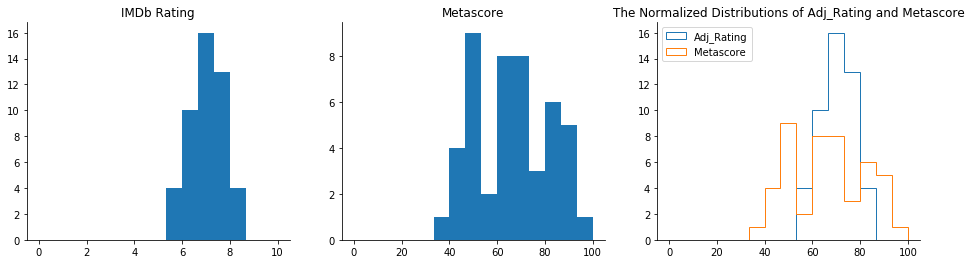

In [7]:
## Plot and analyze the distributions of IMDb rating and metascore
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16,4))
ax1, ax2, ax3 = fig.axes
ax1.hist(movies['Rating'], bins = 15, range = (0,10)) # bin range = 1
ax1.set_title('IMDb Rating')
ax2.hist(movies['Metascore'], bins = 15, range = (0,100)) # bin range = 10
ax2.set_title('Metascore')
ax3.hist(movies['Adj_Rating'], bins = 15, range = (0,100), histtype = 'step')
ax3.hist(movies['Metascore'], bins = 15, range = (0,100), histtype = 'step')
ax3.legend(loc = 'upper left')
ax3.set_title('The Normalized Distributions of Adj_Rating and Metascore')
for ax in fig.axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.show()

<a id='Q12Reviews'></a>
#### Q1.2 : Get 953 movie reviews for the selected 47 IMDb top thriller movie

In this section, 953 movie reviews from 47 movies are extracted with BeautifulSoup web scraping. The reviews are scaled to 1 for positive rRating ('10/10','9/10', '8/10', '7/10') and others as 0 for negative. There are 428 movie reviews assigned to "1" as positive reviews and 525 movie reviews assigned to "0" as negative reviews. 

[Back to top](#BacktoTop)

In [8]:
# Reviews functions to get 25 movie reviews per page url
def reviews(movie_title ="Avengers: Infinity War",url = "http://www.imdb.com//title/tt4154756/reviews?ref_=tt_ov_rt"):
    
    rTitle =[]
    rAuthor =[]
    rDate =[]
    rRating =[]
    rReview =[]
    rReviews ={}
    
    res = get(url)
    soup = BeautifulSoup(res.text,"lxml")

    main_content = urljoin(url, soup.select(".load-more-data")[0]['data-ajaxurl'])
    response = get(main_content)
    
    broth = BeautifulSoup(response.text,"lxml")

    for item in broth.select(".review-container"):   
        
        title = item.select(".title")[0].text.splitlines()
        rTitle = rTitle + title
        
        review = str(item.select(".text")[0].text)
        rReview =rReview +[review]
        
        try:
            score= item.select(".ipl-ratings-bar")[0].text.split('\n')[7]
            rRating =rRating +[score]
        except:
            score="?"
            rRating =rRating +[score]

        reviewer= item.select(".display-name-date")[0].text.split('\n')[1].split()[0]
        
        rdate= str(item.select(".display-name-date")[0].text.split('\n')[1].split()[1])+'/'+str(item.select(".display-name-date")[0].text.split('\n')[1].split()[2])
        
        rAuthor =rAuthor +[reviewer]
        
        rDate =rDate +[rdate]
        
    rReviews.update({"Movie":movie_title, 
                     "rRating":rRating,
                     "rTitle":rTitle, 
                     "rReview":rReview,
                     "rAuthor":rAuthor,
                     "rDate":rDate
                    })
    
    return(pd.DataFrame.from_dict(rReviews))

In [9]:
## Table out put of 25 reviews per movie
rpMovie = pd.DataFrame()
for i in range(movies.shape[0]):
    temp = reviews(movie_title =movies["Movie"][i], url = movies["Link"][i])
    rpMovie =pd.concat([rpMovie, temp], ignore_index =False)
    
## Save dataframe as pickle 
pickle.dump(rpMovie, open( "rpMovie.p", "wb" ) , protocol=2)

In [10]:
## Get rpMovie.p file and check with head()
with open('rpMovie.p', 'rb') as f:
    rpMovie = pickle.load(f)
rpMovie.head(5)

,Movie,rRating,rTitle,rReview,rAuthor,rDate
0,Avengers: Infinity War,10/10,Unlike anything ever done in the history of c...,This movie is the beginning of the culmination...,kjames-2654214,August/2018
1,Avengers: Infinity War,10/10,This movie will blow your mind and break your...,"Over the past decade, Marvel has earned itself...",shawneofthedead25,April/2018
2,Avengers: Infinity War,9/10,Excellent Film,I was amazed to see so many negative reviews; ...,kevintgeisler19,June/2018
3,Avengers: Infinity War,10/10,A Summer Film That IS Even Better Than The Hype,Summer movies often hype themselves as spectac...,garethvk24,April/2018
4,Avengers: Infinity War,10/10,The amount of people that don't understand th...,All the reviews that say this movie has no plo...,blparker-3173827,April/2018


In [11]:
## Scale review rating to 1 for positive rRating ('10/10','9/10', '8/10', '7/10') and others as 0 for negative
rpMovie = rpMovie[rpMovie.rRating!= "?"] # drop undefined rRating row
rpMovie = rpMovie.assign(Scale = np.where(rpMovie['rRating'].isin(['10/10','9/10', '8/10', '7/10']), 1, 0))

Movies_scaled =pd.DataFrame()
for i in np.unique(rpMovie.Movie):
    Temp = rpMovie[rpMovie.Movie==i]
    Temp_1 = Temp[Temp.Scale==1] 
    Temp_0 = Temp[Temp.Scale==0]
    if(len(Temp_1)!=0 or len(Temp_0)!=0): # filter to movies only with "1" or "0"
        Movies_scaled = pd.concat([Movies_scaled,Temp_1.head(15)])
        Movies_scaled = pd.concat([Movies_scaled,Temp_0.head(15)])

In [12]:
## Get the review scale distribution 
print("Movie review numbers:", len(Movies_scaled.Scale),
      "\nMovie review scales:", Counter(Movies_scaled.Scale).keys(),
     "\nMovie review scale values:", Counter(Movies_scaled.Scale).values())

Movie review numbers: 953 
Movie review scales: dict_keys([1, 0]) 
Movie review scale values: dict_values([428, 525])


In [13]:
## Save the scaled dataframe as pickle
pickle.dump(Movies_scaled, open( "Movies_scaled.p", "wb" ) , protocol=2)

<a id='NPChunks'></a>
#### Q2: Extract NP chunks from reviews

Extract noun phrase (NP) chunks from your reviews using the following procedure:

a.	In Python, use BeautifulSoup to grab the main review text from each link.  

b.	Next run each review text through a tokenizer, and then try to NP-chunk it with a shallow parser. 

c.	You probably will have too many unknown words, owing to proper names of characters, actors, and so on that are not in your working dictionary. Make sure the main names that are relevant to the movies in your collection of reviews are added to the working lexicon, and then run the NP chunker again.

[Back to top](#BacktoTop)

In this section, the main review texts are extracted from the saved pickle file (dataframed the movie title, review rating, review title, review author, review date and scale). For preprocessing, expand_contractions() is used for expand sentence contractions, lemming(0 to remove word affixes and get a base form of the word, and remove_stopwords() to remove stopwords. Function clean_and_chunk() to clean, tokenize and chunk the collected reviews with pattern library. After checking the sample chunked review and cleaned tokens for sample review #100, the NP chunks together with other forms of chunks are successfully parsed with parsetree from pattern library. In addition, parsetree from pattern library is more efficient than nltk.RegexpParser which takes longer time to compute.   

In [14]:
## Get Movies_scaled.p file and check with head()
with open('Movies_scaled.p', 'rb') as f:
    Movies_scaled = pickle.load(f)
Movies_scaled.head(10)

,Movie,rRating,rTitle,rReview,rAuthor,rDate,Scale
4,A Quiet Place,10/10,For all the bashers of this movie,1) The actress who is deaf in the movie is dea...,shaneandamy-196294,August/2018,1
5,A Quiet Place,8/10,"Nicely done horror + thriller, quite recommen...","""A Quiet Place"" directed by John Krasinski is ...",NpMoviez17,July/2018,1
6,A Quiet Place,10/10,Love it!,I am Deaf. I realllllly enjoy it!! So it good ...,zechpetersen7,April/2018,1
12,A Quiet Place,8/10,A Quiet Place: As good as they say,A Quiet Place was critically acclaimed and for...,Platypuschow12,November/2018,1
13,A Quiet Place,8/10,Pop Culture Thoughts,Alfred Hitchcock's influence is all over this ...,popculturethoughts31,December/2018,1
14,A Quiet Place,10/10,Great Advocate of Deaf Community!!,"Yes, I am biased for rating A Quiet Place with...",Blogger6621,July/2018,1
15,A Quiet Place,8/10,Tense!,A Quiet Place starts with racking up the tensi...,lynseylinzlu2,April/2018,1
18,A Quiet Place,8/10,Incredibly effective despite small problems,Im a huge John Kasinski fan so I may be slight...,lwdiii7,April/2018,1
24,A Quiet Place,7/10,Tense and Original,"""A Quiet Place"" is a tense and original thrill...",claudio_carvalho10,June/2018,1
0,A Quiet Place,6/10,A great concept with frustrating choices,Anyone who lives in the world and follows movi...,CharlesAncelle10,April/2018,0


In [15]:
## Function expand_contractions (for example: "they're" to "they are") 
def expand_contractions(sentence ="They're coming"): 
    expanded_contraction = contractions.fix(sentence)
    return expanded_contraction 

In [16]:
## Function lemming to remove word affixes and get to a base form of the word 
def lemming(tokens, pos = 'n'):
    lemma = WordNetLemmatizer()    
    lemmad_list =[]
    for i in tokens:
        List =list(nltk.pos_tag([i])[0])[1]
        if(List in ['NNPS','NNS', 'NN']): # nouns
            pos = 'n'
        if(List in ['JJS','JJR']): # adjectives
            pos ='a'
        if(List in ['RB','RBS','RBR','MB', 'VBN', 'VBD', 'VBG']): # verbs and adverbs
            pos ='v'
        lemmad_list= lemmad_list+ [lemma.lemmatize(i, pos)]
    return lemmad_list

In [17]:
## Function remove_stopwords to remove stopwords
def remove_stopwords(tokens):
    stopword_list = nltk.corpus.stopwords.words('english') 
    filtered_tokens = [token for token in tokens if token not in stopword_list] 
    return filtered_tokens 

In [18]:
## Function clean_and chunk to clean, tokenize and chunk the collected reviews. 
## Reference: https://nickcdryan.com/2017/02/13/shallow-parsing-for-entity-recognition-with-nltk-and-machine-learning/
def clean_and_chunk(raw):    
    Tokens =[]
    Tree =[]
    Temp = str(raw).splitlines()
    Chunk = []
    Clean_Sentence =[]
    CleanTokens =[]
        
    for i in Temp:
        sentence = expand_contractions(i) # expand contractions
        Clean_Sentence = Clean_Sentence + [sentence.lower()]
        Tokens = Tokens + nltk.word_tokenize(sentence.lower())
        
    words = [word for word in Tokens if word.isalpha()] # Remove punctuations
    CleanTokens = remove_stopwords(words) # Remove stopwords
    CleanTokens =lemming(CleanTokens) # Lemmetization of the tokens to get root words
    
    for i in Clean_Sentence: # Chunks sentences
        tree = parsetree(i, chunk = "NP") # Parse trees: https://www.clips.uantwerpen.be/pages/pattern-en
        Tree = Tree + tree
        
    for sentence_tree in Tree: 
        Chunk = Chunk + sentence_tree.chunks 
           
    return Chunk, CleanTokens

In [19]:
## Sample chunked review and cleaned tokens for sample review #100
## Chunks, Tokens = clean_and_chunk(list(Movies_scaled.rReview)[100])
Chunks, CleanTokens = clean_and_chunk(list(Movies_scaled.rReview)[100])
print("Sample review #100: ", list(Movies_scaled.rReview)[100],
      "\n\nChunks for movie review #100: ", Chunks,
      "\n\nCleanTokens for movie review #100: ", CleanTokens)

Sample review #100:  Loved everything about this movie. I can't imagine all the negative reviews from people complaining about storyline and acting. This is a Marvel comic turned movie so what great meaningful story can you expect. This is supposed to be sheer entertainment and it checks all the right boxes. Comedy, Action, brilliant Special Effects and really likeable characters. This movie was way better than the first part. 

Chunks for movie review #100:  [Chunk('loved everything/NP'), Chunk('about/PP'), Chunk('this movie/NP'), Chunk('i/NP'), Chunk('cannot imagine/VP'), Chunk('all the negative reviews/NP'), Chunk('from/PP'), Chunk('people/NP'), Chunk('complaining/VP'), Chunk('about/PP'), Chunk('storyline/NP'), Chunk('acting/ADJP'), Chunk('is/VP'), Chunk('marvel/VP'), Chunk('comic turned movie/NP'), Chunk('so/PP'), Chunk('great meaningful story/NP'), Chunk('can/VP'), Chunk('you/NP'), Chunk('expect/VP'), Chunk('is supposed to be/VP'), Chunk('sheer entertainment/NP'), Chunk('it checks

In [20]:
## Get all the tokens and chunks
Chunks = []
Tokens =[]

for i in list(Movies_scaled.rReview):
    chunk, token =clean_and_chunk(i)
    Chunks.append(chunk)
    Tokens.append(token)  
    
Movies_scaled['Chunks'] = Chunks   
Movies_scaled['Tokens'] = Tokens
Movies_scaled = Movies_scaled.reset_index()
del Movies_scaled['index']      

In [21]:
Movies_scaled.head(5)

,Movie,rRating,rTitle,rReview,rAuthor,rDate,Scale,Chunks,Tokens
0,A Quiet Place,10/10,For all the bashers of this movie,1) The actress who is deaf in the movie is dea...,shaneandamy-196294,August/2018,1,"[the actress, is, deaf, in, the movie, is, dea...","[actress, deaf, movie, deaf, real, life, alien..."
1,A Quiet Place,8/10,"Nicely done horror + thriller, quite recommen...","""A Quiet Place"" directed by John Krasinski is ...",NpMoviez17,July/2018,1,"[a quiet place, directed, by, john krasinski, ...","[quiet, place, direct, john, krasinski, genuin..."
2,A Quiet Place,10/10,Love it!,I am Deaf. I realllllly enjoy it!! So it good ...,zechpetersen7,April/2018,1,"[i, am, deaf, i, realllllly enjoy, it, so, it,...","[deaf, realllllly, enjoy, good, people, know, ..."
3,A Quiet Place,8/10,A Quiet Place: As good as they say,A Quiet Place was critically acclaimed and for...,Platypuschow12,November/2018,1,"[a quiet place, was critically acclaimed, for,...","[quiet, place, critically, acclaim, reason, te..."
4,A Quiet Place,8/10,Pop Culture Thoughts,Alfred Hitchcock's influence is all over this ...,popculturethoughts31,December/2018,1,"[alfred hitchcock, influence, is, over, this t...","[alfred, hitchcock, influence, tense, atmosphe..."


In [22]:
## Save Movies_scaled dataframe as pickle (this pickle file is not zipped into submission folder due to its file size)
pickle.dump(Movies_scaled, open( "Movies_reviews.p", "wb" ) , protocol=2)

<a id='OutputChunks'></a>
#### Q3 : Output all the chunks in a single list for each review

Output all the chunks in a single list for each review, and submit that output for this assignment. Also submit a brief written summary of what you did (describe your selection of genre, your source of reviews, how many you collected, and by what means).

[Back to top](#BacktoTop)

In this section, all the chunks in a single list for each review are saved in pickle file. The sample chunks from #100 to #105 of the 954 movie reviews are printed for checking. 

In [23]:
## Get Movie_scaled.p and open as Movies_cleaned (this pickle file is not zipped into submission folder due to its file size)
with open('Movies_reviews.p', 'rb') as f:
    Movies_reviews = pickle.load(f)

In [24]:
##### Print the sample chunks from 100 to 105 of the 954 movie reviews
print("Sample chunks from 90 to 100 of the 954 movie reviews:")
for i in range(90,100):
    print('\n\nMovie Title :', Movies_reviews.Movie[i], 
          "\nMovie Review Rating: ", Movies_reviews.rRating[i], 
          "\nMovie Review Chunks: ", Movies_reviews.Chunks[i])

Sample chunks from 90 to 100 of the 954 movie reviews:


Movie Title : Annihilation 
Movie Review Rating:  3/10 
Movie Review Chunks:  [Chunk('i/NP'), Chunk('was expecting/VP'), Chunk('a mind/NP'), Chunk('bending/VP'), Chunk('make/VP'), Chunk('you/NP'), Chunk('ask/VP'), Chunk('questions/NP'), Chunk('of/PP'), Chunk('your own existence kind/NP'), Chunk('of/PP'), Chunk('movie/NP'), Chunk('did not get/VP'), Chunk('at/PP'), Chunk('all.what i/NP'), Chunk('did get was/VP'), Chunk('a slow , huge plot hole/NP'), Chunk('mess/NP'), Chunk('of/PP'), Chunk('a boring/NP'), Chunk('did not ask/VP'), Chunk('any questions/NP'), Chunk('at/PP'), Chunk('all really kind/NP'), Chunk('of/PP'), Chunk('movie.nearly fell/VP'), Chunk('asleep/ADVP'), Chunk('i/NP'), Chunk('would have/VP'), Chunk('except/PP'), Chunk('the guy/NP'), Chunk('2/PP'), Chunk('rows/NP'), Chunk('behind/PP'), Chunk('me/NP'), Chunk('was snoring/VP'), Chunk('too loudly/ADVP')]


Movie Title : Annihilation 
Movie Review Rating:  1/10 
Movie Revie

<a id='Summary'></a>
#### Summary

In this homework, 953 thriller movie reviews from 47 movies are extracted with BeautifulSoup web scraping. The thriller movies are selected as released from 2018. 

The metascore and review rating are used to balance the positive and negative review selections. Usually, "very good"(critical favorites) movies have metascore above 70, correponding to the IMDb rating score around 7. The reviews are classified to two groups: "1" for positive reviews with ratings higher than 7/10, and "0" for negative reviews with rating below 7/10. In total, there are 428 reviews assigned to "1" and 525 reviews assigned to "0".

For noun phrase (NP) chunk extractions, the preprocessing procedures are needed to expand sentence contractions, remove word affixes and get a base form of the word, and remove_stopwords() to remove stopwords. The parsetree function from pattern library is used to chunk the collected reviews after cleaning and tokenization. 

After checking the sample chunked review and cleaned tokens for sample review #100, the NP chunks together with other forms of chunks are successfully parsed with parsetree from pattern library. In addition, parsetree from pattern library is more efficient than nltk.RegexpParser which takes much longer time to compute.

All the chunks in a single list for each review are saved in pickle file for future use. The sample chunks from #100 to #105 of the 953 movie reviews are printed for checking.

[Back to top](#BacktoTop)

#### References

1. IMDB All U.S. Released Movies: 1972-2016 Analysis http://thebigdatascience.com/2018/01/17/imdb-all-u-s-released-movies-1972-2016-analysis/

2. Tutorial: Web Scraping and BeautifulSoup https://www.dataquest.io/blog/web-scraping-beautifulsoup/

3. https://stackoverflow.com/questions/48932995/webscraping-using-beautifulsoup

4. Which movie should I watch? https://medium.com/@nishantsahoo/which-movie-should-i-watch-5c83a3c0f5b1

5. IMDb. https://www.imdb.com/

6. Shallow Parsing for Entity Recognition with NLTK and Machine Learning
https://nickcdryan.com/2017/02/13/shallow-parsing-for-entity-recognition-with-nltk-and-machine-learning/

#### Implementation environments

In [25]:
import platform; print(platform.platform())
import sys; print("Python", sys.version)
import pandas;  print("Pandas", pandas.__version__)
import numpy; print("NumPy", numpy.__version__)
import requests; print("Requests", requests.__version__)
import pickle; print("Pickle", pickle.format_version)
import re; print("Re", re.__version__)
import nltk; print("nltk", nltk.__version__)
import matplotlib; print("Matplotlib", matplotlib.__version__)
import pattern.en; print("Pattern", pattern.__version__)

Darwin-18.6.0-x86_64-i386-64bit
Python 3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Pandas 0.24.2
NumPy 1.16.4
Requests 2.22.0
Pickle 4.0
Re 2.2.1
nltk 3.4
Matplotlib 3.0.2
Pattern 3.6


##### -- The End of Homework 05 --